In [85]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Generate dataframe

In [86]:
inpath = 'data/codedqr-data-3262502.csv'
outpath = None

if (len(sys.argv) == 3):
    inpath = sys.argv[1]
    outpath = sys.argv[2]

print(f'making plots from {inpath}')

# load csv file into a pandas dataframe
df = pd.read_csv(inpath).dropna()

df['total'] = df.iloc[:, 3:].sum(axis=1) - df['recovery']

df = df[['n', 'p', 'f', 'recovery','final solve','post-ortho','cs construct','pbmgs','total']]

# df.to_csv('data/codedqr-data-3249593.csv', index=False)


making plots from data/codedqr-data-3262502.csv


## Total job runtime

In [87]:

seconds = int(df['total'].sum())
mins = seconds // 60
hours = mins // 60
days = hours // 24
seconds %= 60
mins %= 60
hours %= 24

print(f'total execution time: {days}-{hours}:{mins}:{seconds}')


total execution time: 19-22:16:32


## Calculate Proportional Overhead and Sums

In [88]:

# Calculate Tqr for f=0
df['tqr'] = df['pbmgs']

f_zero_dict = df.loc[df['f'] == 0].set_index(['n', 'p'])['tqr'].to_dict()

df.loc[df['f'] != 0, 'tqr'] = df.loc[df['f'] != 0].apply(
    lambda row: f_zero_dict.get((row['n'], row['p']), row['tqr']),
    axis=1
)

# Calculate Tcomp
df['tcomp'] = df['pbmgs'] - df['tqr']

# Take proportions
df['encode'] = df['cs construct'] / df['tqr']
df['post'] = df['post-ortho'] / df['tqr']
df['decode'] = df['recovery'] / df['tqr'] / ( df['p'] + df['f'] )
df['comp'] = df['tcomp'] / df['tqr']

df['overhead'] = df['comp'] + df['encode'] + df['post']

print(df.iloc[:,-5:])

           encode          post        decode      comp      overhead
0    1.476878e-09  2.415391e-07  5.351926e-08  0.000000  2.430159e-07
1    3.530882e-04  5.434734e-04  3.574227e-04  0.262223  2.631194e-01
2    6.142898e-04  3.781488e-04  6.534971e-04  0.536909  5.379011e-01
3    1.010703e-03  3.004641e-04  1.195478e-03  0.800525  8.018362e-01
4    2.289585e-09  3.581759e-07  4.065030e-08  0.000000  3.604655e-07
..            ...           ...           ...       ...           ...
364  1.347912e-10  2.372619e-08  2.510629e-09  0.000000  2.386098e-08
365  1.693942e-04  4.622838e-04  1.880249e-04  0.121087  1.217185e-01
366  3.392061e-04  3.922706e-04  3.649113e-04  0.249576  2.503072e-01
367  4.278017e-04  3.119724e-04  5.179223e-04  0.399493  4.002329e-01
368  1.977587e-10  3.531107e-08  3.688001e-09  0.000000  3.550883e-08

[366 rows x 5 columns]


## Take averages for all iterations

In [89]:
config_cols = ['n', 'f', 'p']

df[config_cols] = df[config_cols].astype(int)

# df_means = df.groupby(config_cols)[df.columns[3:]].median()
# df_std = (df.groupby(config_cols)[df.columns[3:]].quantile(0.75) - df.groupby(config_cols)[df.columns[3:]].quantile(0.25)) / 2

# Sort the rows by total within each group
df_sorted = df.sort_values(['total']).groupby(config_cols)

df_means = df_sorted.apply(lambda x: x.iloc[:][df.columns[3:]].mean())
df_std = df_sorted.apply(lambda x: x.iloc[:][df.columns[3:]].std())


df_means.head()


recovery  final solve  post-ortho  cs construct       pbmgs  \
n     f p                                                                 
12000 0 6   0.000112          0.0    0.000109  5.702281e-07  380.987769   
        8   0.000096          0.0    0.000099  6.036498e-07  264.494649   
        10  0.000103          0.0    0.000105  5.862117e-07  182.159016   
        12  0.000108          0.0    0.000113  5.845375e-07  145.788364   
      1 6   0.955786          0.0    0.294380  1.372268e-01  485.269017   

                 total         tqr       tcomp        encode          post  \
n     f p                                                                    
12000 0 6   380.987879  380.987769    0.000000  1.496779e-09  2.867710e-07   
        8   264.494748  264.494649    0.000000  2.282091e-09  3.732971e-07   
        10  182.159122  182.159016    0.000000  3.218203e-09  5.781601e-07   
        12  145.788477  145.788364    0.000000  4.010879e-09  7.758724e-07   
      1 6   485.700625  382.892750  102.376268  3.583948e-04  7.688322e-04   

                  decode      comp      overhead  
n     f p                                         
12000 0 6   4.913808e-08  0.000000  2.882677e-07  
        8   4.546563e-08  0.000000  3.755792e-07  
        10  5.634241e-08  0.000000  5.813783e-07  
        12  6.200435e-08  0.000000  7.798833e-07  
      1 6   3.566032e-04  0.267376  2.685031e-01

# Absolute time and overhead over $p$

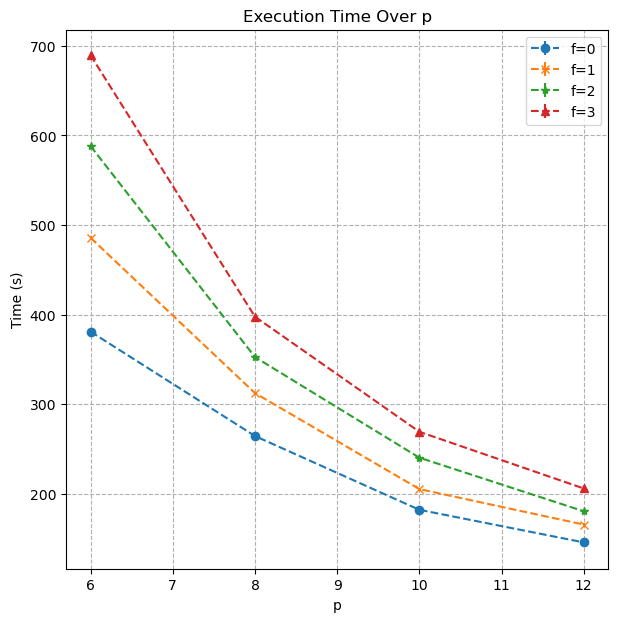

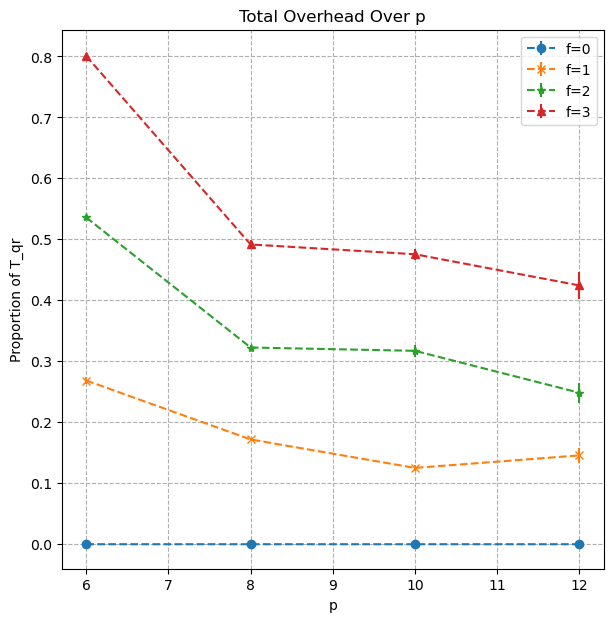

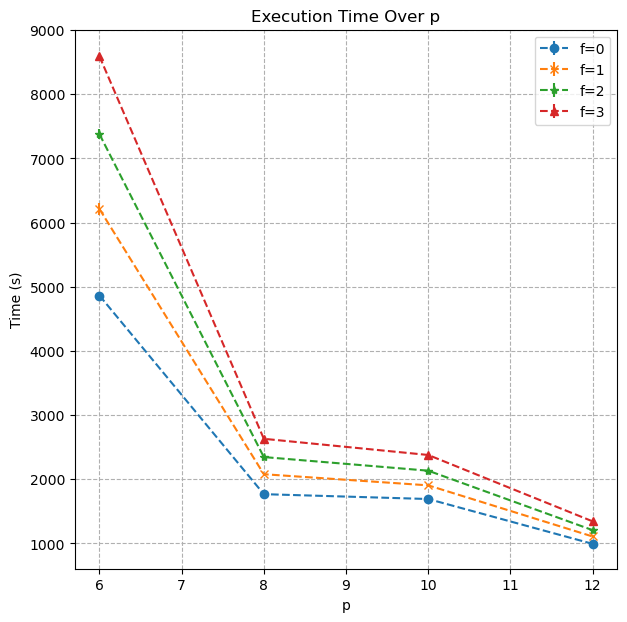

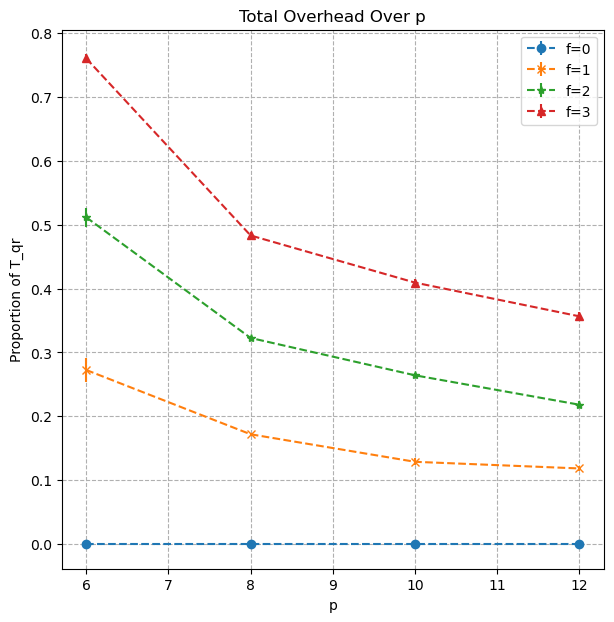

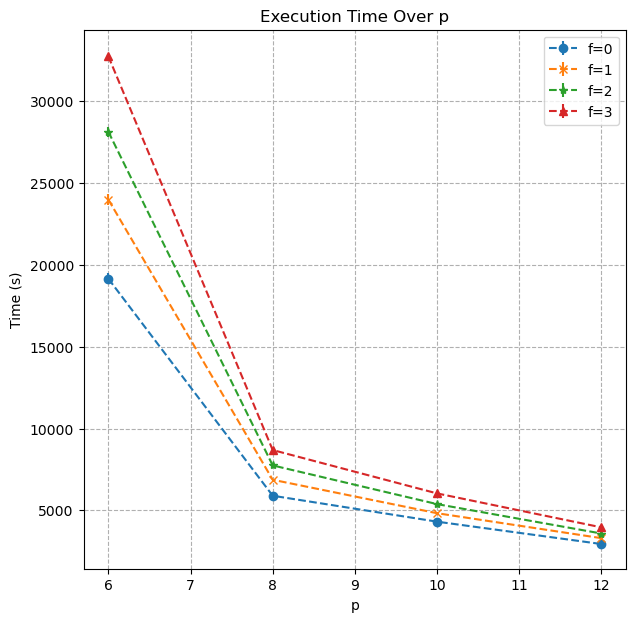

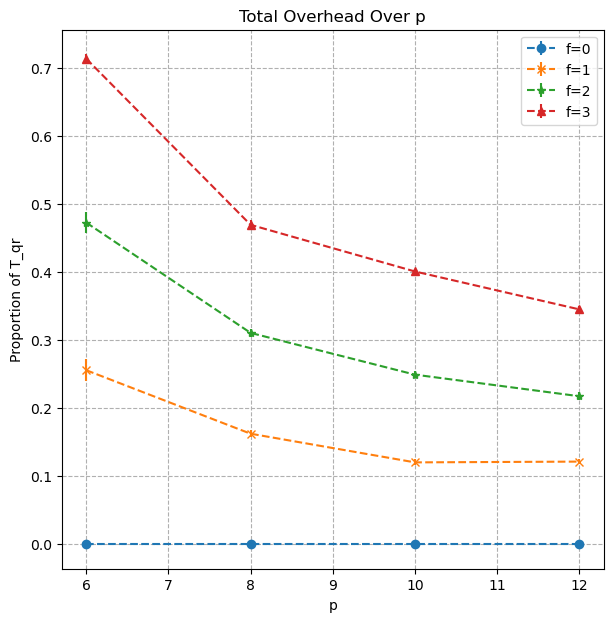

In [90]:

markers = ['o', 'x', '*', '^', 'v', 'p', '>', '<', 'D', 'H']

def inv_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

# fig1, plots1 = plt.subplots(3, 2, figsize=(14,21))   

fig1 = []
plots1 = []

for n_val in df['n'].unique():
    
    n_rows = df_means.query(f"n == {n_val}")
    n_std = df_std.query(f"n == {n_val}")
    
     
    f_time, time = plt.subplots(1,1,figsize=(7,7))
    f_over, overhead = plt.subplots(1,1,figsize=(7,7))
    fig1.extend([f_time, f_over])
    plots1.extend([time, overhead])

    # time, overhead = plots1[int(n_val // 12000 - 1)]
    # fig.text(0.5,0, f'n={n_val}', size=12, ha="center")
    
    for i, f_val in enumerate(df['f'].unique()):
        
        f_rows = n_rows.query(f"f == {f_val}")
        f_std = n_std.query(f"f == {f_val}")
                
        p_vals = f_rows.index.get_level_values('p')
        
        marker = markers[i % len(markers)]
        
        # popt, pcov = curve_fit(inv_exp, p_vals, f_rows['total'])
        # x_fit = np.linspace(min(p_vals), max(p_vals), 1000)
        # y_fit = inv_exp(x_fit, *popt)
        
        time.errorbar(p_vals, f_rows['total'], yerr=f_std['total'], label=f'f={f_val}', linestyle='--', marker=marker)
        overhead.errorbar(p_vals, f_rows['overhead'], yerr=f_std['overhead'], label=f'f={f_val}', linestyle='--', marker=marker)
        # time.plot(x_fit, y_fit, 'r-')
    
    time.set_title(f'Execution Time Over p') 
    time.set_xlabel('p')
    time.set_ylabel('Time (s)')
    time.grid(True, linestyle='--')
    time.legend()
    
    overhead.set_title(f'Total Overhead Over p') 
    overhead.set_xlabel('p')
    overhead.set_ylabel('Proportion of T_qr')
    overhead.grid(True, linestyle='--')
    overhead.legend()
    
for fig in fig1:
    fig.show()
       

# Coding Breakdown over $p$

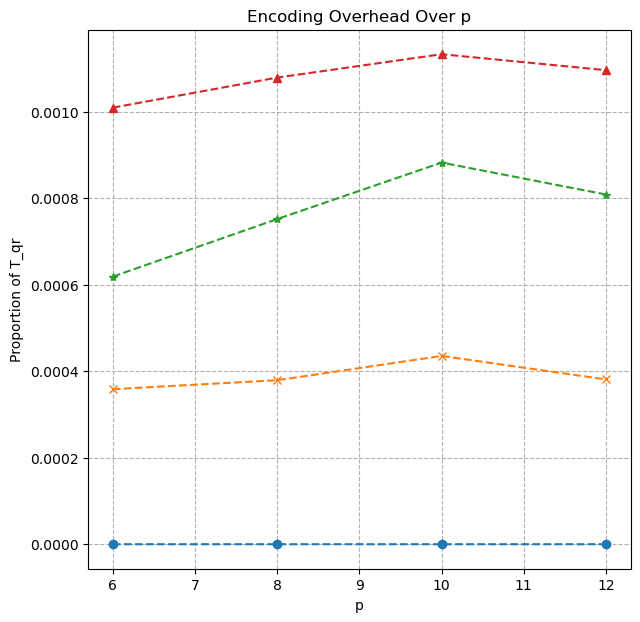

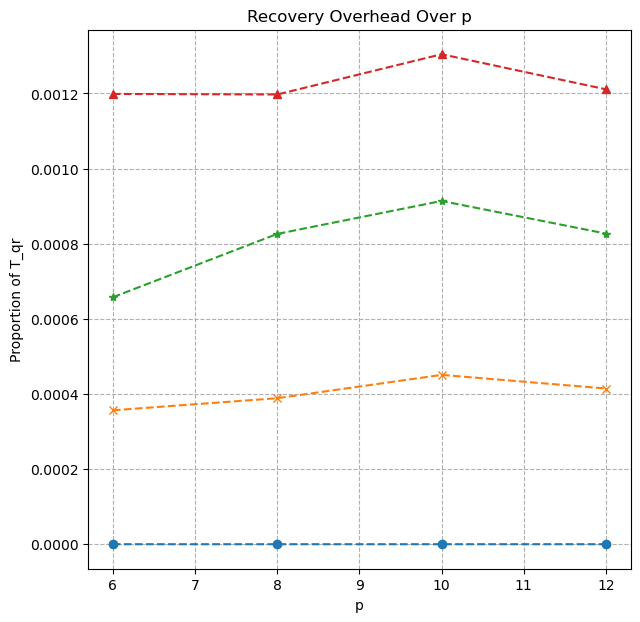

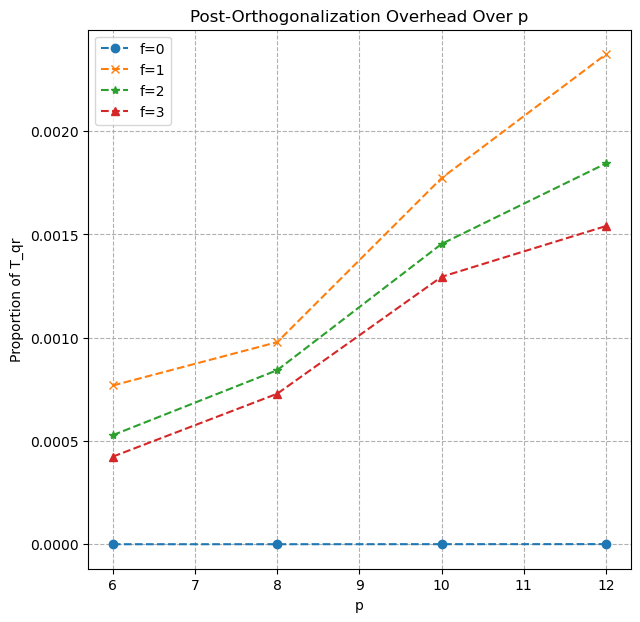

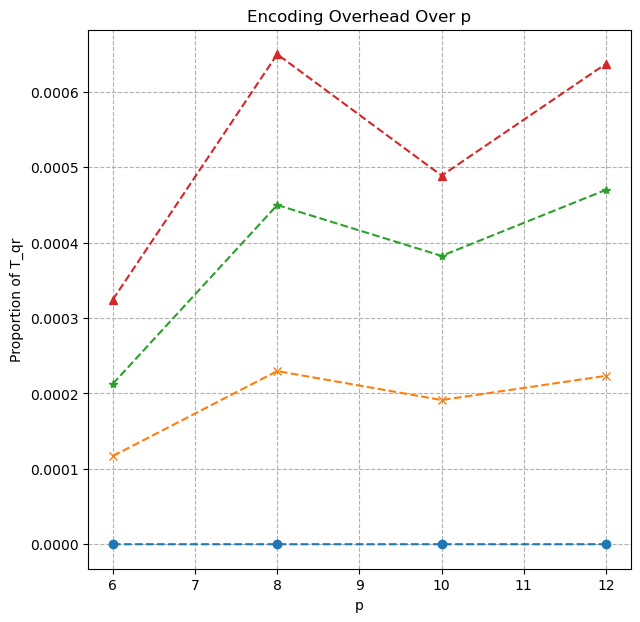

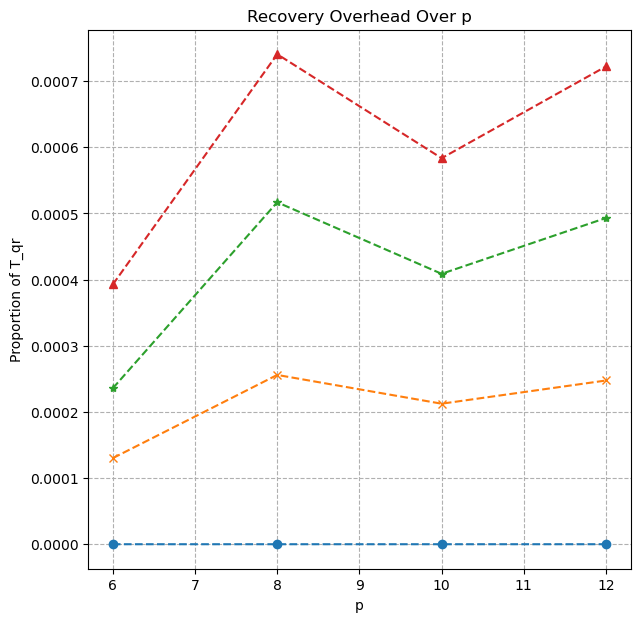

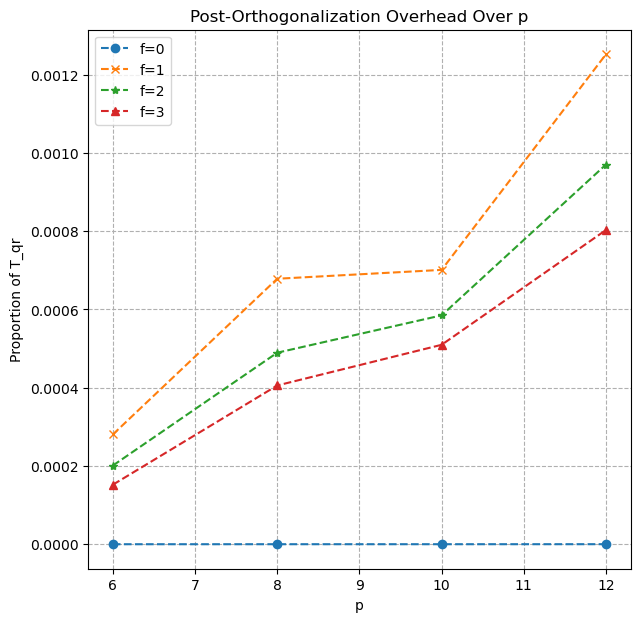

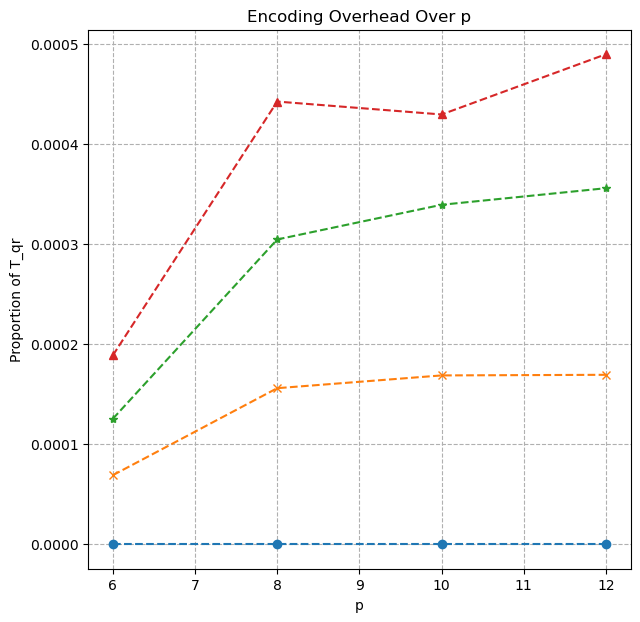

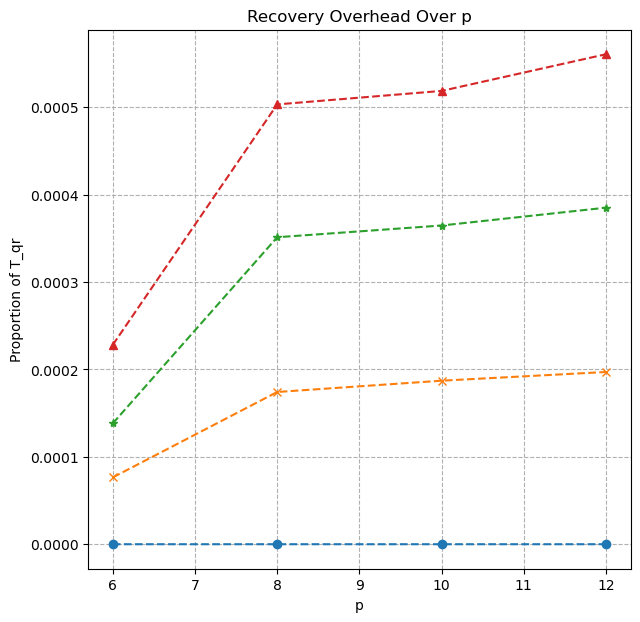

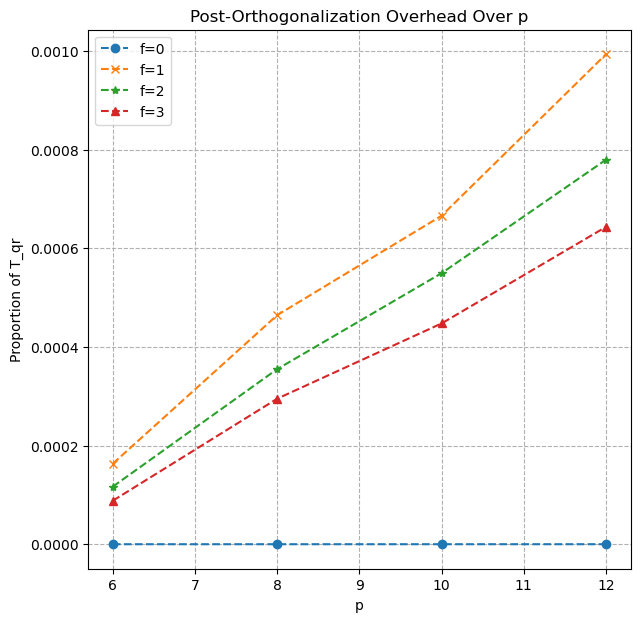

In [91]:
# fig2, plots2 = plt.subplots(3, 3, figsize=(21, 21))

fig2 = []
plots2 = []

for n_val in df['n'].unique():
    
    n_rows = df_means.query(f"n == {n_val}")
    # n_rows.drop('n', axis=1, inplace=True)
    # post, enc, recov = plots2[int(n_val // 12000 - 1)]
    # fig.text(0.5,-0.1, f'n={n_val}', size=12, ha="center") 
    
    f_enc, enc = plt.subplots(1,1,figsize=(7,7))
    f_recov, recov = plt.subplots(1,1,figsize=(7,7))
    f_post, post = plt.subplots(1,1,figsize=(7,7))
    fig2.extend([f_enc, f_recov, f_post])
    plots2.extend([enc, recov, post]) 
  
    for i, f_val in enumerate(df['f'].unique()):
        
        f_rows = n_rows.query(f"f == {f_val}")
        # f_rows.drop('f', axis=1, inplace=True)
        
        p_vals = f_rows.index.get_level_values('p')
        
        marker = markers[i % len(markers)]
        
        enc.plot(p_vals, f_rows['encode'], label=f'f={f_val}', linestyle='--', marker=marker)
        recov.plot(p_vals, f_rows['decode'], label=f'f={f_val}', linestyle='--', marker=marker)
        post.plot(p_vals, f_rows['post'], label=f'f={f_val}', linestyle='--', marker=marker)

    
    enc.set_title(f'Encoding Overhead Over p') 
    enc.set_xlabel('p')
    enc.set_ylabel('Proportion of T_qr')
    enc.grid(True, linestyle='--')
    
    recov.set_title(f'Recovery Overhead Over p')
    recov.set_xlabel('p')
    recov.set_ylabel('Proportion of T_qr')
    recov.grid(True, linestyle='--')
    
    post.set_title(f'Post-Orthogonalization Overhead Over p')
    post.set_xlabel('p')
    post.set_ylabel('Proportion of T_qr')
    post.grid(True, linestyle='--')
    post.legend()
    
for fig in fig2:
    fig.show()


# Overhead over $f$

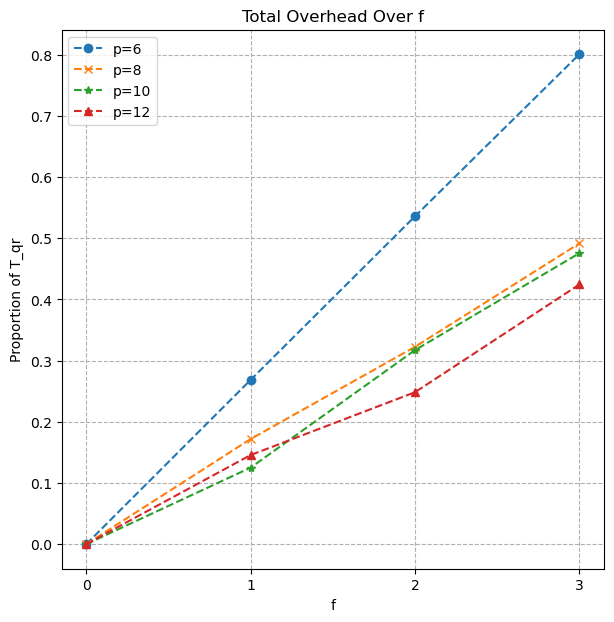

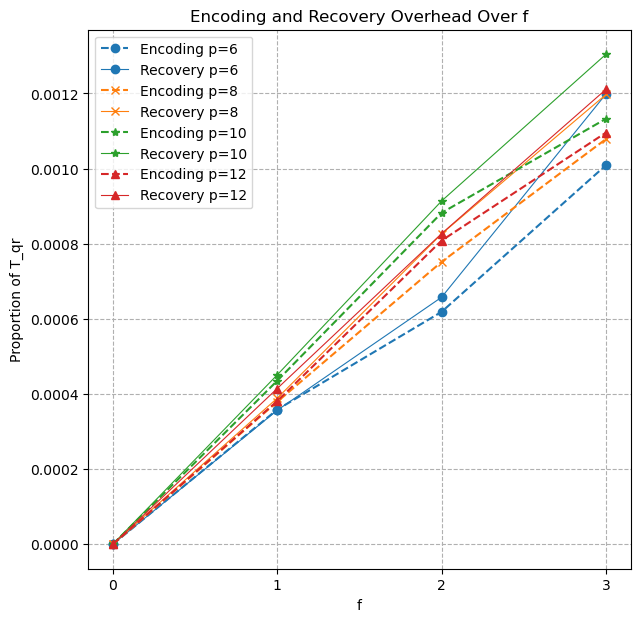

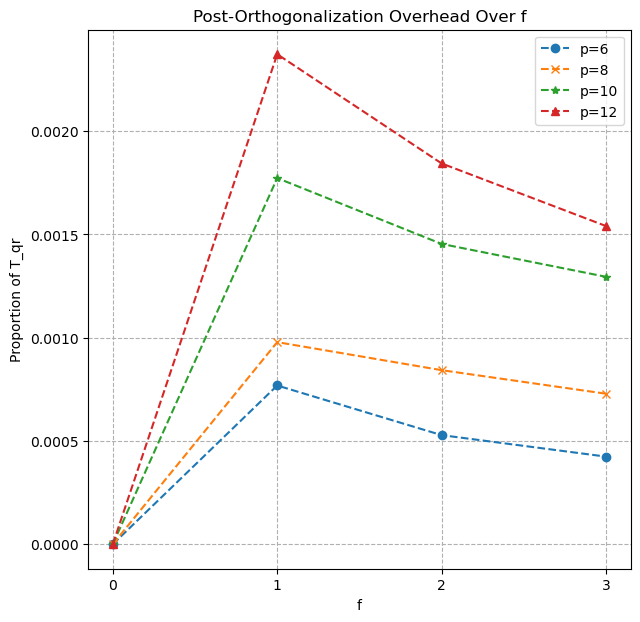

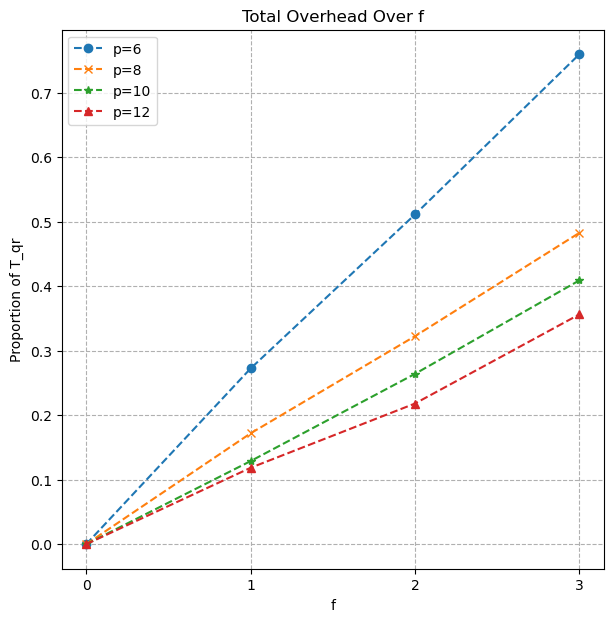

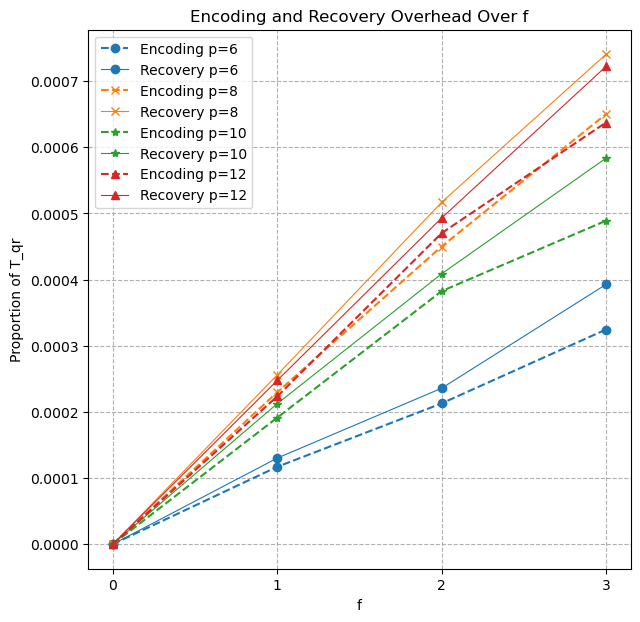

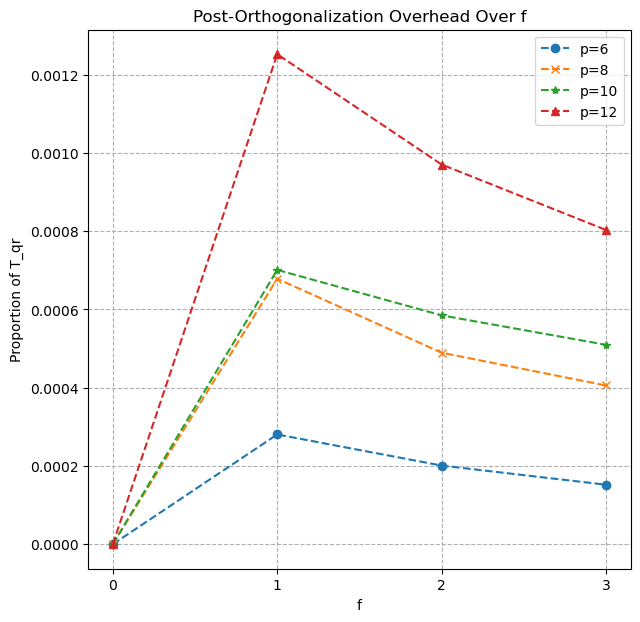

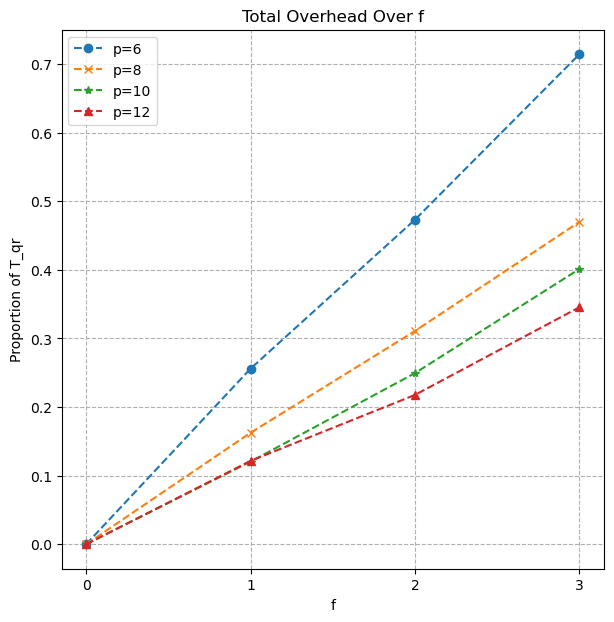

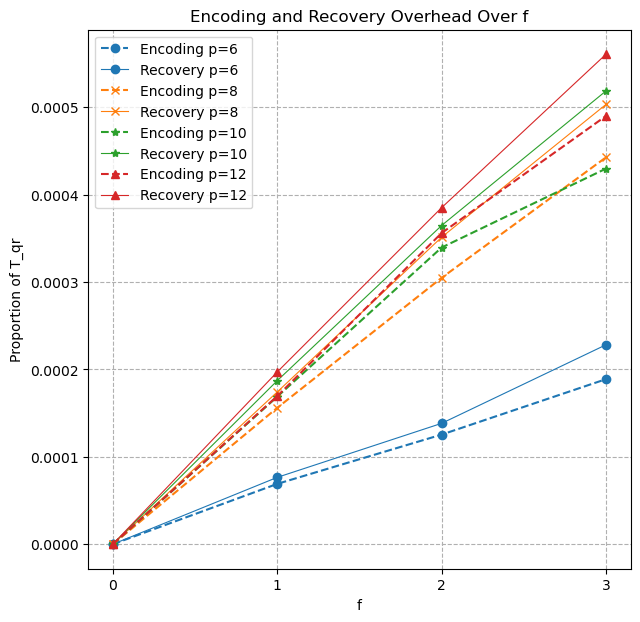

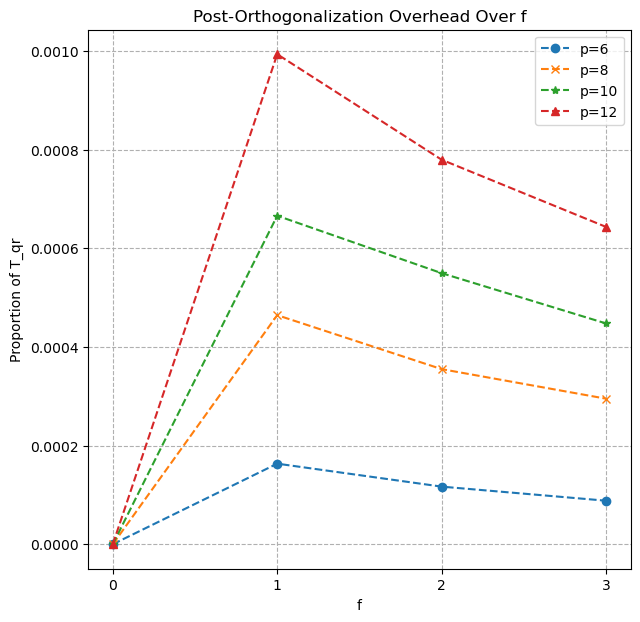

In [92]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# fig3, plots3 = plt.subplots(3, 3, figsize=(21,21))

fig3 = []
plots3 = []

for n_val in df['n'].unique():
    
    n_rows = df_means.query(f"n == {n_val}")
    # n_rows.drop('n', axis=1, inplace=True)
    # overhead, enc, post = plots3[int(n_val // 12000 - 1)]
    # fig.text(0.5,0.05, f'n={n_val}', size=12, ha="center")
    
    f_overhead, overhead = plt.subplots(1,1,figsize=(7,7))
    f_enc, enc = plt.subplots(1,1,figsize=(7,7))
    f_post, post = plt.subplots(1,1,figsize=(7,7))
    fig3.extend([f_overhead, f_enc, f_post])
    plots3.extend([overhead, enc, post])

    for i, p_val in enumerate(df['p'].unique()):
        
        p_rows = n_rows.query(f"p == {p_val}")
        # f_rows.drop('f', axis=1, inplace=True)
        
        f_vals = p_rows.index.get_level_values('f')
        
        marker = markers[i % len(markers)]
        color = colors[i % len(colors)]
        
        overhead.plot(f_vals, p_rows['overhead'], label=f'p={p_val}', linestyle='--', marker=marker, color=color)
        enc.plot(f_vals, p_rows['encode'], label=f'Encoding p={p_val}', linestyle='--', marker=marker, color=color)
        enc.plot(f_vals, p_rows['decode'], label=f'Recovery p={p_val}', linestyle='-', linewidth=0.8, marker=marker, color=color)
        post.plot(f_vals, p_rows['post'], label=f'p={p_val}', linestyle='--', marker=marker, color=color)

    max_f_val = int(df['f'].max())  # Get the maximum 'f' value in your dataframe
    overhead.xaxis.set_ticks(np.arange(0, max_f_val+1, 1))
    enc.xaxis.set_ticks(np.arange(0, max_f_val+1, 1))
    post.xaxis.set_ticks(np.arange(0, max_f_val+1, 1))
    
    overhead.set_title(f'Total Overhead Over f')
    overhead.set_ylabel('Proportion of T_qr')
    overhead.set_xlabel('f')
    overhead.grid(True,linestyle='--')
    overhead.legend()
    
    enc.set_title(f'Encoding and Recovery Overhead Over f') 
    enc.set_ylabel('Proportion of T_qr')
    enc.set_xlabel('f')
    enc.grid(True, linestyle='--')
    enc.legend()

    post.set_title(f'Post-Orthogonalization Overhead Over f')
    post.set_ylabel('Proportion of T_qr')
    post.set_xlabel('f')
    post.grid(True, linestyle='--')
    post.legend()
    
for fig in fig3:
    fig.show()

In [93]:
for n, figs in enumerate([fig1, fig2, fig3]):
    for i, plot in enumerate(figs):
            # Save the Figure object as a PNG file
            plot.savefig(f'figs/plot_{n}_{i}.png', bbox_inches='tight', dpi=300)
            # Close the Figure object to free up memory
            plt.close(plot)